In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [2]:
load_dotenv()

True

In [3]:
model = ChatOpenAI()

In [4]:
class EvaluationSchema(BaseModel):

    feedback: str = Field(description='Detailed feedback for the essay')
    score: int = Field(description='Score out of 10', ge=0, le=10)

In [5]:
structured_model = model.with_structured_output(EvaluationSchema)

/Users/sameergupta/Desktop/campusx-langgraph/langgraph-env/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1928: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [6]:
class UPSCState(TypedDict):

    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [7]:
def evaluate_language(state: UPSCState):

    prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'language_feedback': output.feedback, 'individual_scores': [output.score]}

In [8]:
def evaluate_analysis(state: UPSCState):

    prompt = f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'analysis_feedback': output.feedback, 'individual_scores': [output.score]}

In [9]:
def evaluate_thought(state: UPSCState):

    prompt = f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'clarity_feedback': output.feedback, 'individual_scores': [output.score]}

In [10]:
def final_evaluation(state: UPSCState):

    # summary feedback
    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarity_feedback"]}'
    overall_feedback = model.invoke(prompt).content

    # avg calculation
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

In [11]:
graph = StateGraph(UPSCState)

graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)


graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thought')


graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_thought', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()

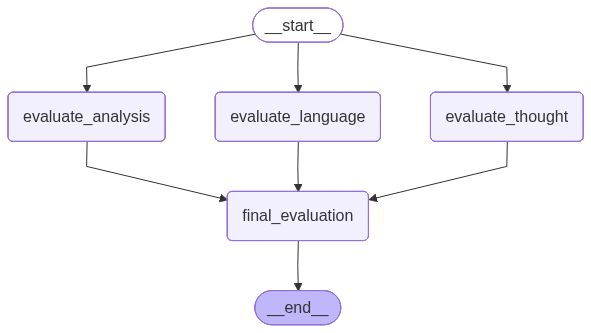

In [12]:
workflow

In [13]:
essay2 = """India and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.

India have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.

India must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If India use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in India have many hope and many danger. We must go right road. AI must help all people, not only some. Then India grow big and world say "good job India"."""


In [14]:
intial_state = {
    'essay': essay2
}

workflow.invoke(intial_state)


{'essay': 'India and AI Time\n\nNow world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.\n\nIndia have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.\n\nIn farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.\n\nBut problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.\n\nOne more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.\n\n